<a href="https://colab.research.google.com/github/5655530/AIFFEL_CORE_QUEST/blob/main/MainQuest06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **데이터셋**
---
이번 노드에서 사용할 데이터는 **캐글의 Chest X-Ray Images** 입니다.

데이터의 구성은 ~/aiffel/chest_xray/data 하위에 3개의 폴더 (train, test, val)로 구성되며, 각 이미지 카테고리 (폐렴 / 정상)에 대한 하위 폴더를 포함합니다. 5,856 개의 X-Ray 이미지 (JPEG)와 2 개의 범주 (폐렴 / 정상)가 있습니다. 전체 데이터의 크기는 총 1.2GB 가량 됩니다.

(에디터 주) 캐글에서 다운로드한 데이터는 chest_xray 하위에 chest_xray 폴더가 중복으로 포함되어 있어서 전체 데이터의 크기가 2.5GB인 경우가 있습니다. 중복된 데이터는 필요하지 않습니다.

해당 이미지는 중국 광저우에 있는 광저우 여성 및 어린이 병원의 1~5 세 소아 환자의 흉부 X선 영상입니다.

아래 코드는 https://www.kaggle.com/code/amyjang/tensorflow-pneumonia-classification-on-x-rays/notebook를 기반으로 작성된 것임을 밝힙니다.

### **1. Set-up**
---
가장 먼저, 패키지(라이브러리)들을 import 해보겠습니다.

우리가 이번 프로젝트에서 사용할 패키지 목록입니다.

In [16]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

앞으로 필요한 변수들을 생성합니다.

1. **BATCH_SIZE**를 **32**로 설정하였습니다.
2. **EPOCHS**를 **15**로 설정하였습니다.

In [69]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join('/content/drive/MyDrive/')
TRAIN_PATH = ROOT_PATH + '/chest_xray/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 32
EPOCHS = 15

print(ROOT_PATH)

/content/drive/MyDrive/


### **2. 데이터 가져오기**
---
import를 했으니 데이터를 가져와 보겠습니다. 데이터를 열어보면 이미 train, val(validation), test 로 나누어져 있습니다. 열어보셨으면 이제 각 데이터들의 개수를 한번 체크해보죠.

아래와 같은 구조의 디렉토리에 이미지 파일들이 각각 담겨있습니다.

In [47]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


train 안에는 5216개, test 안에는 624개, val 안에는 16개가 있습니다.

개수 비는 89%, 10.7%, 0.3% 입니다. val 개수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 더 가져와보겠습니다.

train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할하겠습니다.

In [48]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


이제 train은 4185개, test는 624개, val은 1047개가 되었습니다. test_size를 수정하면 개수는 달라질 수 있습니다.

train 데이터 안에 정상 이미지 수와 폐렴 이미지 수를 한번 보겠습니다.

정상 이미지와 폐렴 이미지를 구분해야 하는데 다행히도 파일 경로에 힌트가 있네요

In [49]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/content/drive/MyDrive//chest_xray/train/NORMAL/NORMAL2-IM-1176-0001.jpeg
Pneumonia image path
/content/drive/MyDrive//chest_xray/train/PNEUMONIA/person10_bacteria_43.jpeg


이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있습니다. 또한, 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.

In [50]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


결과를 보면 정상보다 폐렴 이미지 수가 3배 더 많이 있습니다. 우리가 사용할 CNN 모델의 경우 데이터가 클래스별 balance가 좋을수록 training을 잘 합니다. 데이터가 클래스 불균형(imbalance)한 것은 차후에 조정할 예정입니다. test와 val 데이터셋은 평가하기 위해서 사용되기 때문에 학습과 관련이 없으므로 imbalance한 데이터 셋이어도 문제없습니다.

tf.data 인스턴스를 만들어 봅시다. tf.data는 tensorflow에서 학습시킬 때, mini-batch로 작업할 수 있도록 해 줍니다.

In [51]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

Train 데이터셋, validation 데이터셋 개수 확인을 해보겠습니다.

In [52]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


현재 이미지에는 라벨 데이터가 따로 없습니다.

파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에 이를 이용해서 라벨 데이터를 만들어 주는 함수를 만들어 보겠습니다.

In [53]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

이미지 데이터는 현실적으로 사이즈가 제각각일 가능성이 높습니다.
이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄여봅시다.
decode_img 함수와 process_path 함수를 만들겠습니다.

process_path 함수에서 decode_img 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경합니다. get_label을 이용해서 라벨 값을 가져옵니다.

In [54]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

train 데이터 셋과 validation 데이터 셋을 만듭니다. num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE변수를 이용하면 더욱 빠르게 데이터를 처리해 즐 수 있습니다.

In [55]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

이미지가 잘 리사이즈 되었는지, 그리고 라벨이 잘 들어가 있는지 확인해봅시다.

In [56]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


사이즈가 잘 변환되어 있고 라벨도 잘 들어가 있군요! 참고로, 코드에서 train_ds.take(1)은 하나의 데이터만 가져온다는 의미입니다.

위에서 train과 validation 데이터셋을 만든 것처럼 test 데이터셋도 만들어 보겠습니다. 그리고 데이터 개수도 확인해보겠습니다.

In [57]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


Tensorflow에서는 tf.data 파이프라인을 사용해서 학습 데이터를 효율적으로 사용할 수 있도록 해줍니다. tf.data 파이프라인을 이용하여 prepare_for_training() 함수를 정의해서 데이터를 변환시켜주겠습니다.

shuffle()을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택합니다.

repeat()를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해줍니다.
예를 들어, 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요하게 됩니다. repeat()를 사용하면 자동으로 데이터를 맞춰줍니다.

batch()를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어집니다.
예를 들어, 100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 나뉘게 됩니다.

prefetch()를 사용하면 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있습니다.

## **데이터 준비하기**
---
원본 데이터를 가져와서 전처리 및 배치 구성을 진행합니다.
의료 영상 이미지의 특성상 데이터는 언제나 충분하지 않습니다. 이를 극복할 수 있는 방법을 고민해 봅시다.

이전 실습에서 고려하지 않았던 augmentation 기법을 고려해 볼 수 있을 것입니다. 그러나 의료 영상인 경우, 일반적인 이미지 처리에서 사용하는 augmentation들이 항상 도움이 된다고 말할 수 없습니다. 특히 X-RAY 같은 의료 영상의 특성상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있기 때문입니다.
그래서 augmentation 도입은 신중해야 합니다.

좌우 반전 정도의 augmentation만 도입한다고 한다면 다음과 같이 진행될 것입니다.

In [58]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### **3. 데이터 시각화**
---
데이터를 보기 위해 먼저, train에 있는 batch 중 첫 번째 배치를 추출합니다. 추출된 배치를 image와 label 데이터 셋으로 나눕니다. 이제 show_batch() 함수를 이용해서 결과 사진을 보겠습니다.

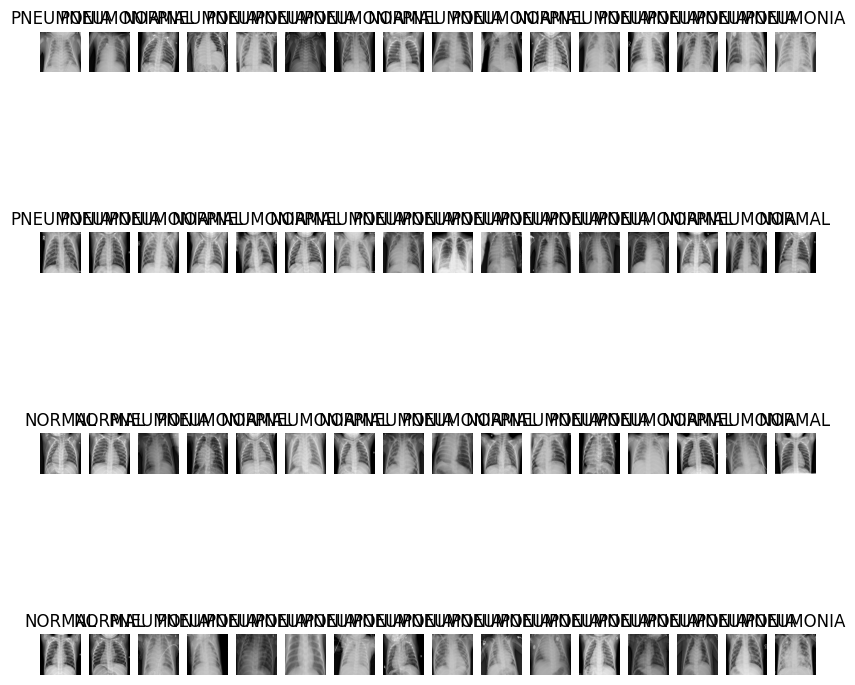

In [59]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

### **4. CNN 모델링**
---
이미지 처리에 특화된 딥러닝 모델인 CNN을 통해 모델링을 하고 결과를 만들어 보겠습니다.

먼저, Convolution block을 만듭니다. conv_block()의 구성은 Convolution을 두 번 진행하고 Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결합니다. 그리고 Max Pooling을 합니다.

In [31]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])

    return block

Dense Block은 아래와 같이 만듭니다.

In [32]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

    return block

우리가 만들 CNN 모델은 약간의 수정을 거쳐 만들어진 모델입니다. 전형적인 CNN 모델과는 약간 다른 모델입니다.

어떤 부분이 가장 특이한가요? 눈에 띄셨을지 모르겠지만, 방금 만들어진 모델에는 Batch Normalization과 Dropout이라는 두 가지 regularization 기법이 동시에 사용되고 있습니다.
일반적으로 이런 방법은 잘 사용되지 않거나, 금기시되기도 합니다. 대표적으로 아래와 같은 논문의 사례를 들 수 있습니다.

- https://openaccess.thecvf.com/content_CVPR_2019/papers/Li_Understanding_the_Disharmony_Between_Dropout_and_Batch_Normalization_by_Variance_CVPR_2019_paper.pdf

위 논문에서는 variance shift를 억제하는 Batch Normalization과 이를 유발하는 Dropout을 동시에 사용하는 것이 어울리지 않는다고 밝히고 있습니다.

그러나, 실용적으로는 두 방법을 같이 쓰는 것이 낫다고 보는 견해도 없는 것은 아닙니다. 예외적으로 동시에 사용하는 것이 성능 향상에 도움을 주는 경우가 실제로 있습니다. 아래 논문과 같이 두 방법을 같이 쓰는 것을 옹호하는 경우도 있습니다.

- https://arxiv.org/pdf/1905.05928.pdf

이번 실습에서는 두 가지를 함께 사용하는 이 모델이 성능 향상에 도움이 될지 여부도 흥미롭게 살펴볼만 한 부분입니다.

In [33]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),

        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),

        conv_block(32),
        conv_block(64),

        conv_block(128),
        tf.keras.layers.Dropout(0.2),

        conv_block(256),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),

        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model

### **5. 데이터 imbalance 처리**
---
'Normal'과 폐렴에서 'Pneumonia' 중에 'Pneumonia' 데이터가 많이 있었죠? 한 라벨이 너무 많은 경우를 imbalance 하다고 하는데, 데이터를 학습할 때 imbalance한 데이터의 경우 학습 효과가 좋지 않을 수 있습니다.

이런 문제들을 해결하는 방법으로 Weight balancing이라는 테크닉이 사용됩니다. Weight balancing 은 training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법입니다. Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원하고 있습니다.

아래 코드에서 weight_for_0은 'Normal' 이미지에 사용할 weight를, weight_for_1은 'Pneumonia' 이미지에 사용할 weight를 세팅합니다. 이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정됩니다.

In [34]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


### **6. 모델 훈련**
---
이미지 훈련은 GPU를 사용할 것이기 때문에 먼저 GPU를 선택합니다. 모델은 위에서 만들었던 모델 함수인 build_model()을 model에 선언합니다.

이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용합니다. optimizer로 'adam'을 사용합니다.
성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용합니다.

In [35]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

모델을 fit 해보겠습니다. 각 파라미터에 위에서 선언했었던 변수, 데이터 셋을 가져와서 각각에 맞게 넣어줍니다. 학습하는데 시간이 꽤 걸립니다.

In [ ]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/15
130/130 [==============================] - 238s 2s/step - loss: 0.0560 - accuracy: 0.9794 - precision: 0.9957 - recall: 0.9766 - val_loss: 0.2137 - val_accuracy: 0.9307 - val_precision: 0.9167 - val_recall: 0.9960
Epoch 2/15
130/130 [==============================] - 199s 2s/step - loss: 0.0661 - accuracy: 0.9764 - precision: 0.9937 - recall: 0.9745 - val_loss: 0.1695 - val_accuracy: 0.9263 - val_precision: 0.9949 - val_recall: 0.9044
Epoch 3/15
130/130 [==============================] - 210s 2s/step - loss: 0.0582 - accuracy: 0.9758 - precision: 0.9946 - recall: 0.9729 - val_loss: 0.3154 - val_accuracy: 0.8818 - val_precision: 0.9976 - val_recall: 0.8409
Epoch 4/15
 45/130 [=========>....................] - ETA: 1:04 - loss: 0.0387 - accuracy: 0.9837 - precision: 0.9971 - recall: 0.9808

### **7. 결과 확인**
---
이제 결과를 확인해보겠습니다. 그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 보여줍니다.

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

테스트 데이터로 모델 평가를 해보겠습니다.

모델 평가를 위해 loss, accuracy, precision, recall 값을 출력해보겠습니다.

In [ ]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

이제 여러분들도 페렴 진단에 있어서 약 80% 정도는 맞출 수 있게 되었습니다.
의사분들이 90% 이상이시니 거의 비슷한 실력이라기에는 다소 모자라는 느낌은 있지만 의료 보조 용도로는 어느 정도 쓸만한 모델이라고는 할 수 있겠습니다.

그럼 성능을 좀 더 개선해볼 수 있는 방법은 없을까요?
오늘 우리가 다룬 폐렴 데이터를 기반으로 한 연구도 많이 찾아볼 수 있습니다.

의료 데이터의 경우 구하기도 어렵고 구하더라도 데이터가 작은 경우가 많이 있습니다. 이런 문제를 해결하기 위해 Data augmentation 방법을 많이 시도합니다.
Data augmentation 은 각 데이터에 최적화된 방법을 찾기가 어렵고 제약사항이 많습니다. 그래서 의료분야에서는 기본적인 Data augmentation 방법들을 많이 사용합니다. 이미지 회전, 가우시안 노이즈 추가 방법 등을 많이 사용합니다. 특히 장기의 크기는 사람마다 거의 바뀌지 않습니다. 이런 특성을 이용한 방법이 노이즈 추가 방법입니다.

전통적인 Data augmentation 방법 이외에도 GAN을 이용해서 Data augmentation을 시도하는 연구들도 많이 있으니 참고하시면 좋을 것 같습니다.

### **8. ResNet-18 구현**
---

이번 스텝에서는 ResNet-18 구현을 진행합니다. ResNet은 2015년 ILSVRC 대회 (ImageNet Large Scale Visual Recognition Challenge)에서 엄청난 성능을 보여주었던 모델입니다.

ResNet의 특징이라면 Residual Connection으로 학습된 정보가 데이터 처리과정에서 손실되는 것을 방지했다는 점입니다. ResNet의 Residual Connection은 이후에 나오는 Transformer와 같은 모델에도 사용되고 있습니다.

우리는 ResNet의 가장 작은 버전인 ResNet-18로 구현하려고 합니다.

아래 그림을 보고 ResNet을 구현해봅니다.

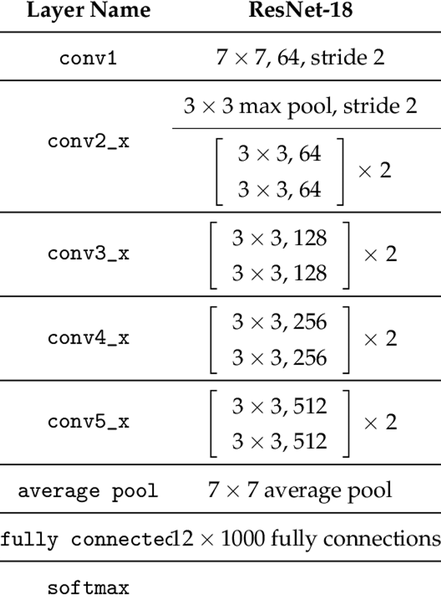

ResNet에서 사용되는 Residual Block은 크게 두 종류로 나뉩니다: **Identity Block과 Projection Block.**

### **1. Identity Block:**

  - 입력 x의 차원이 해당 block의 출력 차원과 동일할 때 사용됩니다.
  -입력 x는 shortcut (또는 skip connection)을 통해 레이어들을 건너뛰고 직접 출력과 합산됩니다.
이는 "identity" shortcut이라고 불리우며, 출력이 F(x)+x가 됩니다.
  - 주로, 입력과 출력의 feature map 크기와 깊이 (채널 수)가 동일한 경우에 사용됩니다

In [60]:
def identity_block(x, filters):
    # Skipconnection
    shortcut = x

    # First convolution
    x = tf.keras.layers.Conv2D(filters, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(filters, 3, padding='same')(x)

    # Adding shortcut to the output
    x = tf.keras.layers.Add()([x, shortcut])
    x = tf.keras.layers.ReLU()(x)

    return x

### **2. Projection Block:**

  - 입력 x의 차원과 해당 block의 출력 차원이 다를 때 사용됩니다.
  - 이런 차이를 해결하기 위해, shortcut 경로에 1x1 convolution이 추가됩니다. 이를 통해 입력의 차원을 변경하여 출력 차원과 일치시킵니다. 이 작업을 "projection"이라고 부릅니다.
이는 "identity" shortcut이라고 불리우며, 출력이 F(x)+x가 됩니다.
  - 주로, 다운샘플링이 필요하거나 feature map의 깊이를 변경해야 할 경우에 사용됩니다.

In [61]:
def projection_block(x, filters, filters_out):
    # Shortcut with projection (to match dimensions)
    shortcut = tf.keras.layers.Conv2D(filters_out, 1, strides=2, padding='same')(x)

    # First convolution
    x = tf.keras.layers.Conv2D(filters, 3, strides=2, activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(filters_out, 3, padding='same')(x)

    # Adding shortcut to the output
    x = tf.keras.layers.Add()([x, shortcut])
    x = tf.keras.layers.ReLU()(x)

    return x

Dense 블록은 아래와 같이 만듭니다.

In [62]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    return block

위의 그림처럼 ResNet-18을 만들기 위해 레이어를 구성합니다.

In [63]:
def build_resnet18():
    input_layer = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

    # Initial Convolution
    x = tf.keras.layers.Conv2D(64, (7, 7), strides=2, activation='relu', padding='same')(input_layer)
    x = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=2, padding="same")(x)

    x = identity_block(x, 64)
    x = projection_block(x, 64, 128)

    x = identity_block(x, 128)
    x = projection_block(x, 128, 256)

    x = identity_block(x, 256)
    x = projection_block(x, 256, 512)

    x = identity_block(x, 512)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # Fully Connected layer with 1000 units for classification
    x = tf.keras.layers.Dense(1000, activation='softmax')(x)

    model = tf.keras.Model(inputs=input_layer, outputs=x)
    return model

In [64]:
model = build_resnet18()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_22 (Conv2D)             (None, 90, 90, 64)   9472        ['input_4[0][0]']                
                                                                                                  
 max_pooling2d_11 (MaxPooling2D  (None, 45, 45, 64)  0           ['conv2d_22[0][0]']              
 )                                                                                                
                                                                                            

모델의 성능을 높이기 위해 하이퍼 파라미터를 조정합니다.

1. **Adam optimizer**의 **learning rate**를 **'0.0001'**로 설정하였습니다.
2. **10 epoch** 이후부터 **learning rate**를 **0.9**배 감소시키는 **scheduler**를 추가하였습니다.
3. **'model.fit()'** 호출 시, 위에서 정의한 **scheduler callback**을 추가하였습니다.

모델의 학습률을 초기에는 **'0.0001'**로 설정하였고, **10 epoch**이 지난 후부터는 학습률을 점차 감소시키는 전략을 적용하였습니다.

In [65]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

# Optimizer와 Learning rate 설정
optimizer = tf.keras.optimizers.Adam(lr=0.0001)

# Learning rate scheduler 함수 정의
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.9

# Callback 리스트에 추가
callbacks = [tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)]

# 모델 컴파일
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=METRICS
)

In [66]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/15
65/65 [==============================] - 132s 2s/step - loss: 0.4105 - accuracy: 0.8166 - precision: 0.9091 - recall: 0.8372 - val_loss: 0.6340 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 2/15
65/65 [==============================] - 101s 2s/step - loss: 0.2492 - accuracy: 0.8916 - precision: 0.9793 - recall: 0.8727 - val_loss: 0.6208 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 3/15
65/65 [==============================] - 137s 2s/step - loss: 0.1900 - accuracy: 0.9255 - precision: 0.9840 - recall: 0.9147 - val_loss: 1.4687 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 4/15
65/65 [==============================] - 130s 2s/step - loss: 0.1564 - accuracy: 0.9413 - precision: 0.9847 - recall: 0.9358 - val_loss: 1.1352 - val_accuracy: 0.7285 - val_precision: 0.7285 - val_recall: 1.0000
Epoch 5/15
65/65 [==============================] - 129s 2s/step - loss: 0.1214 - accuracy: 0.9550 - precisi

### **9. 결과 확인**
---
이제 결과를 확인해보겠습니다. 그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 보여줍니다.

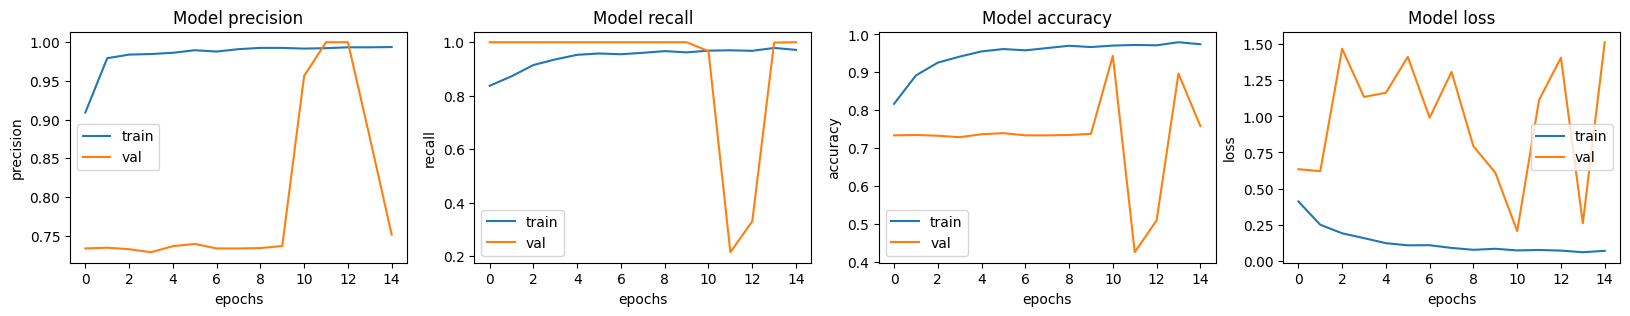

In [67]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

테스트 데이터로 모델 평가를 해보겠습니다.

모델 평가를 위해 loss, accuracy, precision, recall 값을 출력해보겠습니다.

In [68]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

10/10 [==============================] - 19s 2s/step - loss: 5.6675 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 5.667503833770752,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0
